In [31]:
import numpy as np
from matplotlib import pyplot as plt
from sympy import Eq, symbols, init_printing, simplify, Matrix
init_printing()

In [37]:
x_ = np.linspace(1910, 2000, num = 10)
f_ = np.array([92228496, 106021537, 123202624, 132164569, 151325798,
               179323175, 203211926, 226545805, 248709873, 281421906])

x = symbols('x')

def f(arr, f_, d):
    if len(arr) == 1:
        return d[arr[0]]
    return (f(arr[1 :], f_, d) - f(arr[: len(arr) - 1], f_, d)) / (arr[len(arr) - 1] - arr[0])

class interpolant:
    def __init__(self, x_, f_):
        self.x, self.f, self.P_Lagrange, self.P_Newton = x_, f_, 0, 0
        
    def interpolation(self):
        P = 0
        for k in range(len(x_)):
            l = 1
            for i in range(len(x_)):
                if i != k:
                    l *= (x - x_[i]) / (x_[k] - x_[i])
            P += l * f_[k]
        self.P_Newton = P
        
        d, P, m = dict(zip(x_, f_)), 0, 1
        for i in range(len(x_)):
            P += m * f(x_[0:i + 1], f_, d)
            m *= x - x_[i]
        self.P_Lagrange = P
        
    def printing(self, s):
        if s == 'Newton':
            print('Интерполянт методом Ньютона:')
            display(Eq(symbols('P'), simplify(self.P_Newton)))
        elif s == 'Lagrange':
            print('Интерполянт методом Лагранжа:')
            display(Eq(symbols('P'), simplify(self.P_Lagrange)))
        
    def image(self, s):
        p = []
        x__ = np.linspace(min(x_), max(x_) + 10, num = len(x_) * 4)
        if s == 'Newton':
            for i in range(len(x__)):
                p.append(self.P_Newton.subs({x: x__[i]}))
            color_ = 'blue'
        elif s == 'Lagrange':
            for i in range(len(x__)):
                p.append(self.P_Lagrange.subs({x: x__[i]}))
            color_ = 'green'
            
        fig, ax = plt.subplots()
        ax.plot(x__, p, '--', label = 'интерполяция', color = color_)
        ax.plot(self.x, self.f, '.', label = 'исходные данные', color = 'red')
        ax.set_title(s, fontfamily = 'fantasy', size = 16)
        ax.legend()
        ax.set_xlabel('год')
        ax.set_ylabel('население')
        plt.show()
        
    def find_solution(self, p):
        print(round(self.P_Newton.subs({x: p})))

In [41]:
class CubicSpline:
    def __init__(self, x_, f_):
        self.x, self.f = x_, f_
        self.N = len(x_)
        N = len(x_)
        self.h = np.zeros(N - 1)
        for i in range(N - 1):
            self.h[i] = x_[i + 1] - x_[i]
        self.dict_ = dict(zip(x_, f_))
        self.a, self.b, self.c, self.d = 0, 0, 0, 0
        self.matrix, self.sol, self.s = 0, 0, 0
        
    def coeffs1(self):
        N = self.N
        x_, f_, h, dict_ = self.x, self.f, self.h, self.dict_
        a, b, c, d = np.zeros(N - 1), np.full(N - 1, 2), np.zeros(N - 1), np.zeros(N - 1)

        for i in range(1, N - 1):
            a[i] = h[i - 1] / (h[i - 1] + h[i])
        for i in range(N - 2):
            c[i] = h[i] / (h[i - 1] + h[i])
        for i in range(N - 1):
            if i == 0:
                arr = [x_[0], x_[1], x_[2]]
            elif i == N - 2:
                arr = [x_[N - 3], x_[N - 2], x_[N - 1]]
            else:
                arr = [x_[i - 1], x_[i], x_[i + 1]]
            d[i] = 6 * f(arr, f_, dict_)
        self.a, self.b, self.c, self.d = a, b, c, d
    
    def create_matrix(self):
        N = self.N
        a, b, c = self.a, self.b, self.c
        A = np.zeros((N - 1, N - 1))
        for i in range(N - 1):
            if i == 0:
                A[i, i], A[i, i + 1] = b[i], c[i]
            elif i == N - 2:
                A[i, i - 1], A[i, i] = a[i], b[i]
            else:
                A[i, i - 1], A[i, i], A[i, i + 1] = a[i], b[i], c[i]
        self.matrix = A
    
    def solveTriagonalSlae(self):
        N = self.N
        A, a, b, c, d = self.matrix, self.a, self.b, self.c, self.d
        p, q = np.zeros(N - 1), np.zeros(N - 1)
        p[0], q[0] = -c[0] / b[0], d[0] / b[0]
        for i in range(N - 2):
            p[i + 1] = -c[i] / (a[i] * p[i] + b[i])
            q[i + 1] = (d[i] - a[i] * q[i]) / (a[i] * p[i] + b[i])

        sol = np.zeros(N - 1)
        sol[N - 2] = (d[N - 2] - a[N - 2] * q[N - 2]) / (a[N - 2] * p[N - 2] + b[N - 2])
        j = N - 3
        for i in range(N - 2):
            sol[j] = sol[j + 1] * p[j + 1] + q[j + 1]
            j -= 1
        self.sol = sol
    
    def coeffs2(self):
        N = self.N
        x_, f_, h, sol, dict_ = self.x, self.f, self.h, self.sol, self.dict_
        a, b, c, d = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

        a = f_
        c = np.concatenate([sol, [0]], axis = 0)

        b[0] = c[0] * h[0] / 3 + f([x_[0], x_[1]], f_, dict_)
        for i in range(1, N):
            b[i] = c[i] * h[i - 1] / 3 + c[i - 1] * h[i - 1] / 6 + f([x_[i - 1], x_[i]], f_, dict_)

        d[0] = c[0] / h[0]
        for i in range(1, N):
            d[i] = (c[i] - c[i - 1]) / h[i - 1]
        self.a, self.b, self.c, self.d = a, b, c, d
    
    def create_s(self):
        N = self.N
        a, b, c, d, x_ = self.a, self.b, self.c, self.d, self.x
        x = symbols('x')
        s = Matrix(np.zeros(N))
        for i in range(N):
            s[i] = a[i] + b[i] * (x - x_[i]) + c[i] / 2 * (x - x_[i]) ** 2 + d[i] / 6 * (x - x_[i]) ** 3
        self.s = s

    def image(self):
        N = self.N
        x, s, x_, f_ = symbols('x'), self.s, self.x, self.f
        fig, ax = plt.subplots(1, 1)
        ax.plot(x_[:int(N)], f_[:int(N)], '.', color = 'red', label = 'исходные данные')
        for i in range(1, int(N)):
            x__ = np.linspace(x_[i - 1], x_[i], num = 8)
            p = []
            for j in range(len(x__)):
                p.append(s[i].subs({x: x__[j]}))
            ax.plot(x__, p, '--', color = 'blue', label = 'сплайн')
            if i == 1:
                ax.legend()
        ax.set_xlabel('год')
        ax.set_ylabel('население')
                
    def print_(self):
        N = self.N
        s = self.s
        for i in range(N):
            display(Eq(symbols('s_' + str(i + 1)), simplify(s[i])))
                
    def create_spline(self):
        self.coeffs1()
        self.create_matrix()
        self.solveTriagonalSlae()
        self.coeffs2()
        self.create_s()
        self.image()
                        
    def find_solution(self, p):
        print(round(self.s[self.N - 1].subs({x: p})))

Интерполянт методом Ньютона:


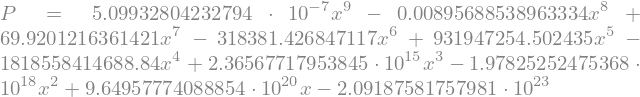

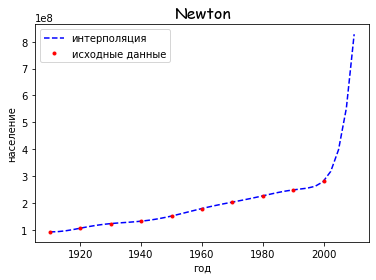

827906509


In [42]:
P = interpolant(x_, f_)
P.interpolation()
P.printing('Newton')
P.image('Newton')
P.find_solution(2010)

314133939


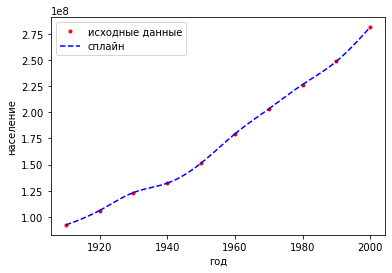

In [44]:
spl = CubicSpline(x_, f_)
spl.create_spline()
spl.find_solution(2010)